In [117]:
import preprocessing.read as r
import preprocessing.st_ops as ops
import preprocessing.feature_ops as feat
import visualization.builders as vis

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from torch_geometric.data import Data
from torch_geometric.data import Batch

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

from IPython.display import HTML
from IPython.display import display

import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy import stats

from pythreejs import *

from math import pi
from numpy import inf

import imageio

import sklearn

# Configurações

In [35]:
num_node = 16
kernel_strategy = 'group' # Opções: 'group' / 'distance'
batch_size = 512
new_samples_per_athlete = 1000
unfold = True

![title](skeleton_model.png)

In [3]:
adj_list = {
    0: [3, 7, 15, 6],
    1: [3, 8, 15, 6],
    2: [15, 6],
    3: [0, 1, 4, 5, 15, 6],
    4: [3, 5, 12, 6],
    5: [3, 4, 11, 6],
    6: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    7: [0, 9, 6],
    8: [1, 10, 6],
    9: [7, 6],
    10: [8, 6],
    11: [5, 13, 6],
    12: [4, 14, 6],
    13: [11, 6],
    14: [12, 6],
    15: [0, 1, 2, 3, 6]
}

In [4]:
joint_map = {
            2: ('head', 0, 2),
            15: ('neck', 0, 1),
            3: ('chest', 0, 0),
            6: ('aggregator', 3, 0),
            0: ('left_shoulder', 1, 1),
            7: ('left_elbow', 1, 2),
            9: ('left_hand', 1, 3),
            1: ('right_shoulder', 2, 1),
            8: ('right_elbow', 2, 2),
            10: ('right_hand', 2, 3),
            4: ('right_rib', 4, 1),
            12: ('right_knee', 4, 2),
            14: ('right_foot', 4, 3),
            5: ('left_rib', 5, 1),
            11: ('left_knee', 5, 2),
            13: ('left_foot', 5, 3)
        }

In [5]:
node_html_colors = { 
    0: '#FFFF00',
    1: '#02FF00',
    2: '#666666',
    3: '#FF00FF',
    4: '#02FF00',
    5: '#FFFF00',
    6: '#666666',
    7: '#FF9802',
    8: '#02FFFF',
    9: '#FF0000',
    10: '#0600FF',
    11: '#FF9802',
    12: '#02FFFF',
    13: '#FF0000',
    14: '#0600FF',
    15: '#FF00FF'
}

# Leitura dos dados

In [312]:
loader = r.TaekwondoLoader('../dataset')
athletes, labels, label_idx = loader.load();
print(labels)
print(athletes[0])
print(label_idx)

idx_label = { idx: key for (idx, key) in enumerate(labels)}

{'Back Kick', 'Left Kick To The Head', 'Left Punch', 'Right Kick', 'Right Punch', 'Left Kick', 'Right Kick To The Head'}
Athlete  9
	Right Punch -> 1 frames
	Right Kick -> 1 frames
	Right Kick To The Head -> 1 frames
	Left Punch -> 1 frames
	Left Kick -> 1 frames
	Left Kick To The Head -> 1 frames
	Back Kick -> 1 frames

{'Back Kick': 0, 'Left Kick To The Head': 1, 'Left Punch': 2, 'Right Kick': 3, 'Right Punch': 4, 'Left Kick': 5, 'Right Kick To The Head': 6}


In [321]:
frame = athletes[0].get('Back Kick')
print(frame[0])
print('Formato atual de um frame [V C] {}'.format(frame[0].shape))
print('Formato atual de uma sequencia [F V C] {}'.format(frame.shape))

[[-262.731964  293.560059 2668.121582]
 [ -16.163462  244.943848 2735.909668]
 [-105.628372  469.698547 2737.811279]
 [-170.320801   64.891304 2667.748291]
 [-110.006447 -157.448898 2658.550781]
 [-292.381317 -121.489807 2608.411133]
 [   0.          0.          0.      ]
 [-262.731323   19.326324 2668.121582]
 [  58.041443    8.270645 2787.517578]
 [-263.123871 -254.906403 2667.475098]
 [ 195.561874 -141.554062 2609.847656]
 [-363.564575 -534.083496 2619.784912]
 [ -58.074657 -572.039429 2632.944824]
 [-473.743225 -910.322388 2616.136963]
 [  24.978374 -925.219727 2631.661621]
 [-139.447723  269.251953 2702.015625]]
Formato atual de um frame [V C] (16, 3)
Formato atual de uma sequencia [F V C] (43, 16, 3)


# Preprocessamento

No preprocessamento é feito uma normalização dos dados. O esqueleto é centralizado em torno da origem e uma escala é aplicada de forma que os dados fiquem entre -1 e 1. O mesmo fator de escala é aplicado nas 3 dimensões para que não ocorra uma distorção espacial.

In [322]:
def normalize_data(athletes):
    for athlete in athletes:

        min_y = float("inf")
        max_y = -float("inf")
        min_x = float("inf")
        max_x = -float("inf")
        min_z = float("inf")
        max_z = -float("inf")

        for _, activity in athlete.activities.items():
            for sample in activity:
                min_x = min(min_x, sample[:,:,0].min())
                max_x = max(max_x, sample[:,:,0].max())
                min_y = min(min_y, sample[:,:,1].min())
                max_y = max(max_y, sample[:,:,1].max())
                min_z = min(min_z, sample[:,:,2].min())
                max_z = max(max_z, sample[:,:,2].max())
            
        scale = (max_y - min_y)/2  # A mesma escala será usada nas 3 dimensões para preservar proporção
        move_x = -(min_x + max_x)/2
        move_y = -(min_y + max_y)/2
        move_z = -(min_z + max_z)/2

        for _, activity in athlete.activities.items():
            for sample in activity:
                sample[:,:,0] = (sample[:,:,0] + move_x)/scale
                sample[:,:,1] = (sample[:,:,1] + move_y)/scale
                sample[:,:,2] = (sample[:,:,2] + move_z)/scale
                
print(athletes[0].get('Back Kick')[0, :, :])
normalize_data(athletes)
print("NORMALIZED DATA: ")
print(athletes[0].get('Back Kick')[0, :, :])

[[-262.731964  293.560059 2668.121582]
 [ -16.163462  244.943848 2735.909668]
 [-105.628372  469.698547 2737.811279]
 [-170.320801   64.891304 2667.748291]
 [-110.006447 -157.448898 2658.550781]
 [-292.381317 -121.489807 2608.411133]
 [   0.          0.          0.      ]
 [-262.731323   19.326324 2668.121582]
 [  58.041443    8.270645 2787.517578]
 [-263.123871 -254.906403 2667.475098]
 [ 195.561874 -141.554062 2609.847656]
 [-363.564575 -534.083496 2619.784912]
 [ -58.074657 -572.039429 2632.944824]
 [-473.743225 -910.322388 2616.136963]
 [  24.978374 -925.219727 2631.661621]
 [-139.447723  269.251953 2702.015625]]
NORMALIZED DATA: 
[[-0.15279017  0.698985    1.53822257]
 [ 0.16380543  0.63656146  1.62526292]
 [ 0.04893189  0.92514799  1.62770461]
 [-0.03413362  0.4053728   1.53774326]
 [ 0.04331041  0.1198865   1.5259336 ]
 [-0.19086014  0.16605821  1.46155396]
 [ 0.18455942  0.32205193 -1.88766329]
 [-0.15278935  0.34686706  1.53822257]
 [ 0.25908502  0.3326715   1.69152782]
 [-0.1

In [323]:
def data_augmentation(athletes, rotate=True, noise=True, rotation_angle=50, noise_intensity=0.1):  
    n_athletes = len(athletes)
    
    for base_idx in range(n_athletes):
        angle = np.random.randint(rotation_angle) - (rotation_angle/2)
        scale_noise = (2*np.random.random() - 1)  * noise_intensity
        base_athlete = athletes[base_idx]
        for label, base_activity in base_athlete.activities.items():
            base_sample = base_activity[0] ## Original sample
            if rotate:
                base_sample = feat.rotate(base_sample, angle)
            if noise:
                base_sample = feat.apply_noise(base_sample, noise_intensity)
                base_sample = feat.scale_noise(base_sample, scale_noise)
            athletes[base_idx].add(label, base_sample)

In [324]:
print(f"Quantidade de movimentos por classe: {len(athletes[0].activities['Back Kick'])}")
for i in range(new_samples_per_athlete):
    data_augmentation(athletes, rotation_angle=60, noise_intensity=0.2)
print(f"Quantidade de movimentos por classe: {len(athletes[0].activities['Back Kick'])}")

Quantidade de movimentos por classe: 1
Quantidade de movimentos por classe: 1001


# Criação do dataset

Preparando os dados para alimentar a rede. Algumas trasnformações são aplicadas.
- Crio uma sequencia de taekwondo, misturando as ações de forma a criar uma sequencia de frames que compreendem várias atividades
- Desdobramento de features (passo opcional), que desdobra as features no estilo onehot-encoding, considerando que cada articulação do esqueleto é uma classe. Assim o espaço de features sai de 3 dimensões para 3x16=48 dimensões.
- Ajustes no shape dos dados de entrada, pois a STGCN espera os dados na forma de um tensor no formato [N C F V] sendo N = Número de Samples, C = Dimensão do espaço de features, F = Número de frames e V = Número de articulações do esqueleto (ou arestas do grafo)

In [154]:
class TaekwondoDataset(Dataset):
   
    def __init__(self, athletes, transform=None):

        self.transform = transform
        self.athletes = []
        for base_athlete in athletes:
            labels = list(base_athlete.activities.keys())
            n_samples = len(base_athlete.activities[labels[0]])
            for sample_idx in range(n_samples):
                new_athlete = r.TaekwondoAthlete(0, parent = base_athlete)   
                for label in labels:
                    frames = base_athlete.get(label, sample_idx)
                    new_athlete.add(label, frames)
                self.athletes.append(new_athlete)
            
        self.athletes = np.array(self.athletes)
        # print('Dataset size: {}'.format(len(self.athletes))) 
       
    def __len__(self):
        return len(self.athletes)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = self.athletes[idx] 
        
        if self.transform:
            sample = self.transform(sample)
        return sample

In [17]:
class BuildTaekwondoSequence(object):
    
    def __init__(self, label_idx, max_lenght=None, shuffle_sequence=False):
        self.label_idx = label_idx
        self.max_lenght = max_lenght
        self.shuffle_sequence = shuffle_sequence

    def __call__(self, sample):
        labels = list(sample.activities.keys())
        if self.shuffle_sequence:
            np.random.shuffle(labels)
        
        sequence_frames = []
        sequence_labels = []
        for label in labels:
            frames = sample.get(label)
            sequence_frames.append(frames)
            sequence_labels.append(np.ones(frames.shape)[:,:,0]*self.label_idx[label])
            
        sequence_frames = np.concatenate( sequence_frames )
        sequence_labels = np.concatenate( sequence_labels )
        if self.max_lenght:
            sequence_frames = sequence_frames[:self.max_lenght]
            sequence_labels = sequence_labels[:self.max_lenght]
        

        return {'frames': sequence_frames, 'labels': sequence_labels}

In [18]:
class UnfoldActivityFeatures(object):
    
    def __init__(self, num_nodes):
        self.num_nodes = num_nodes

    def __call__(self, sample):
        frames = sample['frames']
        num_frames = frames.shape[0]
        num_nodes = frames.shape[1]
        num_dim = frames.shape[2]
        res = np.zeros((num_frames, num_nodes, self.num_nodes*num_dim))
        for frame_idx in range(num_frames):
            for node_idx in range(num_nodes):
                res[frame_idx, node_idx, num_dim*node_idx:num_dim*(node_idx+1)] = frames[frame_idx, node_idx]

        return {'frames': res, 'labels': sample['labels']}

In [19]:
class ToSTGcn(object):
    
    def __call__(self, sample):
        frames = sample['frames']
        return {'frames': frames.transpose((2, 0, 1)), 'labels': sample['labels']}

In [173]:
if unfold:
    print('Using unfold')
    transform = transforms.Compose([BuildTaekwondoSequence(label_idx, 212, shuffle_sequence=True),
                                    UnfoldActivityFeatures(16),
                                    ToSTGcn()
                                   ])
else:
    print('Not using unfold')
    transform = transforms.Compose([BuildTaekwondoSequence(label_idx, 212, shuffle_sequence=True),
                                ToSTGcn()
                               ])
    

dataset = TaekwondoDataset(athletes, transform=transform)

Using unfold


In [174]:
# Testando a criação de um dataset e obtendo o a dimensão do espaço de features. 
# No treinamento esses conjuntos não são utilizados

cut_point = int(len(athletes)*0.8)
permutation = np.random.permutation(len(athletes))
train_set_idx = permutation[:cut_point]
validation_set_idx = permutation[cut_point:]

train_athletes = [athletes[i] for i in train_set_idx ]
validation_athletes = [athletes[i] for i in validation_set_idx ]

train_dataset = TaekwondoDataset(train_athletes, transform=transform)
validation_dataset = TaekwondoDataset(validation_athletes, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

print("Conferindo o shape de um frame: {}".format(train_dataset[0]['frames'].shape))
input_size = train_dataset[0]['frames'].shape[0]

Conferindo o shape de um frame: (48, 212, 16)


# Definição da estratégia de aprendizado

Nessa fase é definido tamanho do kernel que será utilizado ao aprender pesos que se aplicam ao grafo. Diversas estretégias podem ser utilizadas aqui. Implementei duas:

- Peso por distância ao centro. Nessa estratégia, tomando uma aresta como referência, pesos diferentes são aplicados para arestas que estão mais distântes do centro do esqueleto, mais próximos do centro do esqueleto ou na mesma distância. É a estratégia usada no paper que propôem a ST-GCN
- Peso por grupo. Nessa estratégia colocamos as arestas em grupos e os pesos são atribuidos de acordo com o grupo ao qual a aresta pertence. A ideia aqui é tentar diferenciar partes do corpo, como braço esquerdo (composto por ombro, cotovelo e mão esquerda)

In [175]:
def get_adjacency_by_group(num_node, adj_list, joint_map):
    adj_matrix = np.zeros((kernel_size, num_node, num_node))

    for node_idx in range(num_node):
        part, kernel_idx, center_distance = joint_map[node_idx]
        for neigh_idx in adj_list[node_idx]:
            adj_matrix[kernel_idx, node_idx, neigh_idx] = 1

    norm_coeficient = np.einsum('knm->km', adj_matrix)
    norm_coeficient = 1/norm_coeficient
    norm_coeficient[norm_coeficient == inf] = 0

    temp = np.einsum('knm->kmn', adj_matrix)
    for k in range(kernel_size):
        for n in range(num_node):
            temp[k, n, :] = temp[k, n, :] * norm_coeficient[k, n]
    adj_matrix = np.einsum('kmn->knm', temp)
    return adj_matrix, adj_matrix.shape[0]

In [176]:
def get_adjacency_by_distance(num_node, adj_list, joint_map):
    adj_matrix = np.zeros((3, num_node, num_node))

    for node_idx in range(num_node):
        s_part, s_kernel_idx, s_center_distance = joint_map[node_idx]
        for neigh_idx in adj_list[node_idx]:
            t_part, t_kernel_idx, t_center_distance = joint_map[neigh_idx]
            if s_center_distance < t_center_distance:  
                adj_matrix[0, node_idx, neigh_idx] = 1
            elif s_center_distance > t_center_distance:  
                adj_matrix[1, node_idx, neigh_idx] = 1
            elif s_center_distance == t_center_distance:  
                adj_matrix[2, node_idx, neigh_idx] = 1

    norm_coeficient = np.einsum('knm->km', adj_matrix)
    norm_coeficient = 1/norm_coeficient
    norm_coeficient[norm_coeficient == inf] = 0

    temp = np.einsum('knm->kmn', adj_matrix)
    for k in range(3):
        for n in range(num_node):
            temp[k, n, :] = temp[k, n, :] * norm_coeficient[k, n]
    adj_matrix = np.einsum('kmn->knm', temp)
    return adj_matrix, 3

In [177]:
if kernel_strategy == 'group':
    print('Usando estratégia GRUPO')
    adjacency, kernel_size = get_adjacency_by_group(num_node, adj_list, joint_map)
else:
    print('Usando estratégia DISTÂNCIA')
    adjacency, kernel_size = get_adjacency_by_distance(num_node, adj_list, joint_map)
    
print("Tamanho do kernel: {}".format(kernel_size))

Usando estratégia GRUPO
Tamanho do kernel: 6


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


# Definindo a rede

In [178]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv, ChebConv, SAGEConv
from torch_scatter import scatter_mean

class ST_GCN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 1):
        super().__init__()
        self.kernel_size = kernel_size
        self.t_kernel_size = 5
        self.t_padding = 2
        self.conv = nn.Conv2d(in_channels,
                              out_channels * kernel_size,
                              kernel_size=(self.t_kernel_size, 1),
                              padding=(self.t_padding, 0),
                              stride=(1, 1),
                              dilation=(1, 1),
                              bias=True)
    
    def forward(self, x, A):
        assert A.size(0) == self.kernel_size

        x = self.conv(x)

        n, kc, t, v = x.size()
        x = x.view(n, self.kernel_size, kc // self.kernel_size, t, v)
        x = torch.einsum('nkctv,kvw->nctw', (x, A))

        return x.contiguous(), A

In [179]:
def get_accuracy(out_tensor, labels_tensor):
    out_np = out_tensor.detach().cpu().numpy()
    out_np = np.array(np.argmax(out_np, axis=1))

    labels_np = np.array(labels_tensor.cpu().numpy())
    corrects = np.array(out_np == labels_np)

    result = np.sum(corrects) / (out_np.shape[0] * out_np.shape[1] * out_np.shape[2])
    return result

In [326]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.kernel_size = 1
        self.conv1 = ST_GCN(input_size, 8, kernel_size)
        self.conv2 = ST_GCN(8, 8, kernel_size)
        self.conv3 = ST_GCN(8, 4, kernel_size)
        self.conv4 = ST_GCN(4, 7, kernel_size)
        print("Input size: {}".format(input_size))
        print("Kernel_size: {}".format(kernel_size))
        
    def forward(self, x, A):
        x, A = self.conv1(x, A) 
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x, A = self.conv2(x, A)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x, A = self.conv3(x, A)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x, A = self.conv4(x, A)
        x = F.relu(x)
        return F.softmax(x, dim=1)

[Resultado iteração 0] - Loss: 21.5078 - Val Acc: 0.5956
[Resultado iteração 1] - Loss: 21.2277 - Val Acc: 0.6214
[Resultado iteração 2] - Loss: 21.4155 - Val Acc: 0.5420
[Resultado iteração 3] - Loss: 21.8866 - Val Acc: 0.6420
[49/50] Loss: 21.6259 - Val Acc: 0.5746


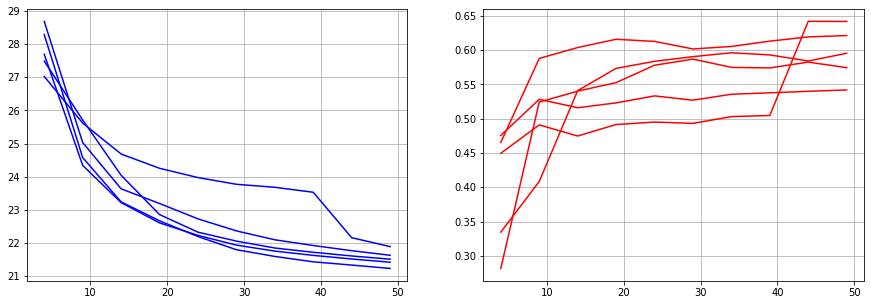

In [181]:
from tqdm import tqdm
import pdb
import torch
import torch.nn as nn
from IPython.display import clear_output, display
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf.get_n_splits(athletes)
epochs = 50
device = torch.device('cuda')
k=0
loss_history_train = []
acc_history_val = []
epoch_history = []
model_history = []
val_idx_history = []
for train_idxs, val_idxs in kf.split(athletes):
    train_athletes = [athletes[i] for i in train_idxs ]
    validation_athletes = [athletes[i] for i in val_idxs ]
    print(train_idxs)
    print(val_idxs)

    train_dataset = TaekwondoDataset(train_athletes, transform=transform)
    validation_dataset = TaekwondoDataset(validation_athletes, transform=transform)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
    
    model = Net().to(device)

    A = torch.from_numpy(adjacency).to(device, dtype=torch.float)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    model.train()
    loss_history_train.append([])
    acc_history_val.append([])
    epoch_history.append([])
    val_idx_history.append(val_idxs)
    for epoch in range(epochs):
        print('Epoca {}'.format(epoch))

        loss_accum = 0
        for samples in train_dataloader:
            data = samples['frames'].to(device, dtype=torch.float)
            labels = samples['labels'].to(device, dtype=torch.long)

            optimizer.zero_grad()

            out = model(data, A)
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimizer.step()
            total_loss = loss.item()
            loss_accum = loss_accum + total_loss


        if (epoch + 1) % 5 == 0:
            model.eval()
            num_samples = 0
            accum = 0
            for samples in validation_dataloader:
                data = samples['frames'].to(device, dtype=torch.float)
                labels = samples['labels'].to(device, dtype=torch.long)
                out = model(data, A)

                accum = accum + get_accuracy(out, labels) * samples['frames'].shape[0]
                num_samples = num_samples + samples['frames'].shape[0]

            validation_accuracy = accum/num_samples

            acc_history_val[k].append(validation_accuracy)
            loss_history_train[k].append(loss_accum) 
            epoch_history[k].append(epoch)
            
            clear_output(wait=True)
            model.train()
            
            for i in range(k):
                final_loss = loss_history_train[i][-1]
                final_val_acc = acc_history_val[i][-1] 
                print('[Resultado iteração {}] - Loss: {:.4f} - Val Acc: {:.4f}'.format(i, final_loss, final_val_acc))
            

            print('[{}/{}] Loss: {:.4f} - Val Acc: {:.4f}'.format(epoch, epochs, loss_accum, validation_accuracy))
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
            for i in range(k+1):
                ax1.plot(epoch_history[i], loss_history_train[i], 'b')
            ax1.grid()
            for i in range(k+1):
                ax2.plot(epoch_history[i], acc_history_val[i], 'r')
            ax2.grid()
            plt.show()
    k = k+1
    model.eval()
    model_history.append(model)
    

In [214]:
label_colors = {
    0: matplotlib.colors.to_rgb('#c62bc6'),
    1: matplotlib.colors.to_rgb('#49bcad'),
    2: matplotlib.colors.to_rgb('#e1ff00'),
    3: matplotlib.colors.to_rgb('#00bbff'),
    4: matplotlib.colors.to_rgb('#ffd800'),
    5: matplotlib.colors.to_rgb('#00ff11'),
    6: matplotlib.colors.to_rgb('#001dff'),
    7: matplotlib.colors.to_rgb('#fff600'),
    8: matplotlib.colors.to_rgb('#d65968'),
}

In [215]:
def create_segmentation_picture(values, nodes_per_frame=16):
    flatten_values = values.flatten()
    picture = np.array([ label_colors[i] for i in flatten_values])
    picture = picture.reshape((-1,nodes_per_frame, 3))
    picture = np.transpose(picture, (1,0,2))
    return picture

In [216]:
def define_label_by_frame(values, nodes_per_frame=16):
    flatten_values = values.flatten()
    frame_wise_mode = stats.mode(flatten_values.reshape((-1, nodes_per_frame)), axis=1)
    frame_pred = frame_wise_mode[0].flatten()
    frame_pred = np.array([ [ i for j in range(16)] for i in frame_pred ])
    return frame_pred

In [319]:
def print_legend():
    fig=plt.figure(figsize=(20, 4))
    for i in idx_label.keys():
        fig.add_subplot(1, 7, i+1)
        plt.imshow(create_segmentation_picture(np.ones((16,16)) * i))
        plt.axis('off')
        plt.title(idx_label[i])
    plt.show()

{'Back Kick': 0, 'Left Kick To The Head': 1, 'Left Punch': 2, 'Right Kick': 3, 'Right Punch': 4, 'Left Kick': 5, 'Right Kick To The Head': 6}


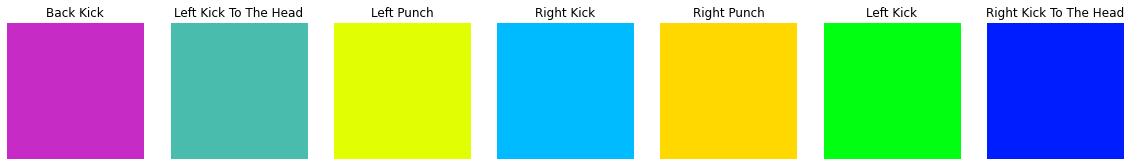

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


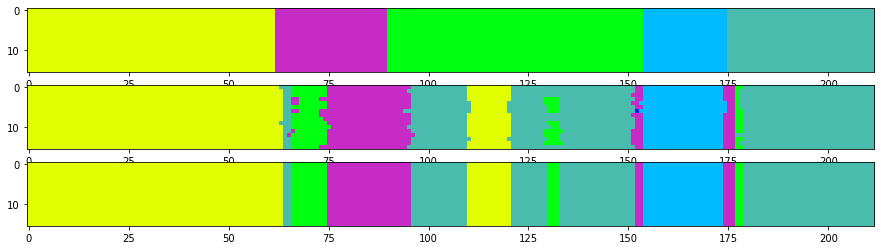

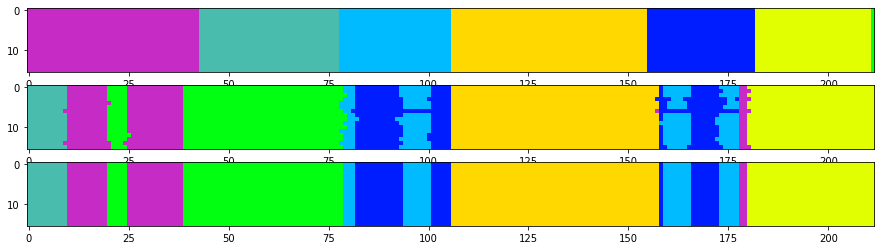

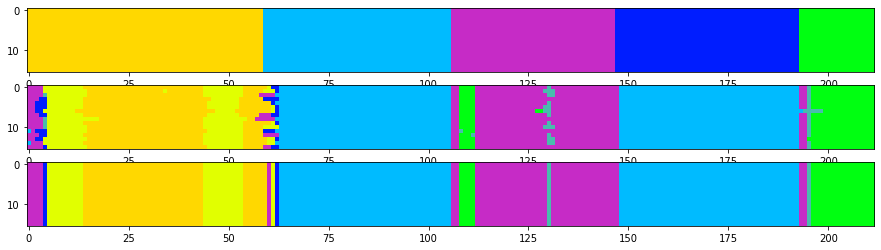

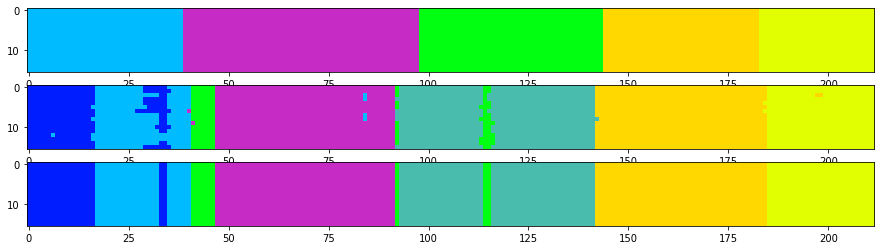

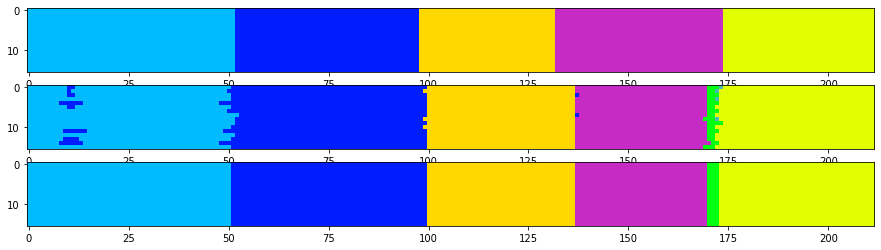

In [327]:
sample_idx = 80
print(label_idx)
print_legend()
for fold in range(len(val_idx_history)):
    validation_dataset = TaekwondoDataset([athletes[i] for i in val_idx_history[fold] ], transform=transform)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

    for samples in validation_dataloader:
        data = samples['frames'].to(device, dtype=torch.float)
        labels = samples['labels'].to(device, dtype=torch.long)
        preds = model_history[fold](data, A)
        preds = torch.argmax(preds, dim=1)
        break;
    sample = data[sample_idx].detach().cpu().numpy();
    pred = preds[sample_idx].detach().cpu().numpy();
    label = labels[sample_idx].detach().cpu().numpy();

    labels_picture = create_segmentation_picture(label)
    preds_by_node_picture = create_segmentation_picture(pred)
    preds_by_frame_picture = create_segmentation_picture(define_label_by_frame(pred))
    
    fig=plt.figure(figsize=(20, 4))
    fig.add_subplot(3, 1, 1)
    plt.imshow(labels_picture)
    fig.add_subplot(3, 1, 2)
    plt.imshow(preds_by_node_picture)
    fig.add_subplot(3, 1, 3)
    plt.imshow(preds_by_frame_picture)

    plt.show()

In [219]:
def confusion_matrix(y_true, y_pred, classes, ax,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, fold_number=0):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import sklearn
    if not title:
        if normalize:
            title = 'Matriz de confusão - FOLD ' + str(fold_number)
        else:
            title = 'Matriz de confisão'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # fig, ax = plt.subplots(figsize=(10, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, animated=True, vmin = 0.0, vmax = 1.0)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    #plt.plot()
    return fig

In [188]:
def classify(array):
    return np.bincount(array).argmax()  

def get_labels(preds):
    try:
        out_np = preds.detach().cpu().numpy()
        out_np = np.array(np.argmax(out_np, axis=1))
    except:
        out_np = preds
    
    results = np.array([np.apply_along_axis(classify, 1, sample) for sample in out_np]) 
    results = results.flatten()
    
    return results

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Presisão geral no fold 0 : 0.5937576574369027
Presisão geral no fold 1 : 0.6223729101087592
Presisão geral no fold 2 : 0.545254274027859
Presisão geral no fold 3 : 0.6441553729289579
Presisão geral no fold 4 : 0.5788174090060882


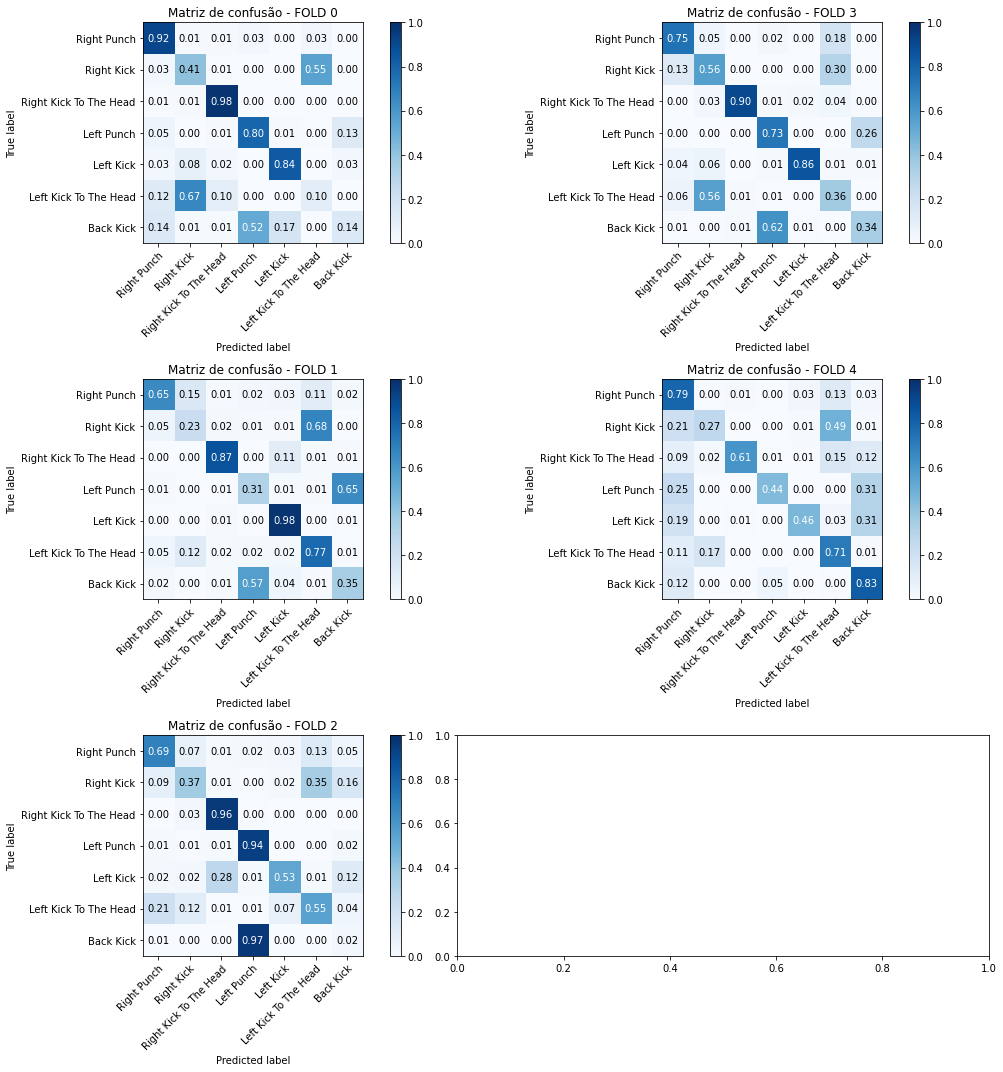

In [328]:
class_names = list(athletes[0].activities.keys())

ims = []
fig, axs = plt.subplots(3, 2, figsize=(15,15))

for fold in range(len(val_idx_history)):
    validation_dataset = TaekwondoDataset([athletes[i] for i in val_idx_history[fold] ], transform=transform)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
    complete_labels = np.array([])
    complete_preds = np.array([])
    for samples in validation_dataloader:
        data = samples['frames'].to(device, dtype=torch.float)
        labels = samples['labels'].to(device, dtype=torch.long)
        preds = model_history[fold](data, A)
        labels = labels[:,:,0].flatten().detach().cpu().numpy()
        preds = get_labels(preds)
        complete_labels = np.concatenate((complete_labels, labels), axis=0)
        complete_preds = np.concatenate((complete_preds, preds), axis=0)
        
    ax = axs[int(fold%3)][int(fold/3)]
    accurracy = np.sum(complete_labels == complete_preds) / len(complete_preds)
    print("Presisão geral no fold {} : {}".format(fold, accurracy)) 
    cm = confusion_matrix(complete_labels, complete_preds, class_names, ax, True, fold_number=fold)            